In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# -----------------------------
# Repro & Config
# -----------------------------
np.random.seed(42)
tf.random.set_seed(42)
CLASS_NAMES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


In [14]:
# -----------------------------
# Data
# -----------------------------

def load_data(img_size=32):
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # Optional tiny compound-resolution scaling for pedagogy
    if img_size != 32:
        x_train = tf.image.resize(x_train, (img_size, img_size)).numpy()
        x_test = tf.image.resize(x_test, (img_size, img_size)).numpy()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    y_train_cat = to_categorical(y_train, 10)
    y_test_cat = to_categorical(y_test, 10)
    return (x_train, y_train, y_train_cat), (x_test, y_test, y_test_cat)


In [15]:
# -----------------------------
# EfficientNet MBConv + SE
# -----------------------------

def swish(x):
    return tf.nn.swish(x)


In [16]:
def squeeze_excitation(x, se_ratio=0.25):
    in_ch = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Reshape((1,1,in_ch))(se)
    se = layers.Conv2D(max(1, int(in_ch*se_ratio)), 1, activation=swish, padding='same')(se)
    se = layers.Conv2D(in_ch, 1, activation='sigmoid', padding='same')(se)
    return layers.Multiply()([x, se])


In [17]:

def mbconv(x, out_ch, expand_ratio=6, kernel_size=3, stride=1, se_ratio=0.25, drop_rate=0.0):
    in_ch = x.shape[-1]
    hidden_ch = int(in_ch * expand_ratio)

    # Expansion phase (1x1 conv)
    if expand_ratio != 1:
        x_exp = layers.Conv2D(hidden_ch, 1, padding='same', use_bias=False)(x)
        x_exp = layers.BatchNormalization()(x_exp)
        x_exp = layers.Activation(swish)(x_exp)
    else:
        x_exp = x

    # Depthwise conv
    x_dw = layers.DepthwiseConv2D(kernel_size, strides=stride, padding='same', use_bias=False)(x_exp)
    x_dw = layers.BatchNormalization()(x_dw)
    x_dw = layers.Activation(swish)(x_dw)

    # Squeeze-and-Excitation
    x_se = squeeze_excitation(x_dw, se_ratio=se_ratio)

    # Projection (1x1 conv)
    x_pw = layers.Conv2D(out_ch, 1, padding='same', use_bias=False)(x_se)
    x_pw = layers.BatchNormalization()(x_pw)

    # Skip connection if shapes match
    if stride == 1 and in_ch == out_ch:
        if drop_rate and drop_rate > 0:
            x_pw = layers.Dropout(drop_rate)(x_pw)
        out = layers.Add()([x_pw, x])
    else:
        out = x_pw
    return out

In [18]:
# -----------------------------
# Model (single MBConv block)
# -----------------------------

def build_efficientnet_one_block(alpha=1.0, img_size=32):
    """
    Minimal EfficientNet-like classifier for CIFAR-10.
    alpha: width multiplier (channels), img_size: optional resolution scaling (compound idea).
    """
    inputs = layers.Input(shape=(img_size, img_size, 3))

    # Stem conv
    c1 = int(32 * alpha)
    x = layers.Conv2D(c1, 3, strides=1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)

    # Single MBConv (downsample to aggregate)
    c2 = int(64 * alpha)
    x = mbconv(x, out_ch=c2, expand_ratio=6, kernel_size=3, stride=2, se_ratio=0.25, drop_rate=0.0)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs, name=f"efficientnet_one_block_a{alpha}_r{img_size}")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [19]:
# -----------------------------
# Training + Visualizations
# -----------------------------

def plot_history(history):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epochs'); plt.legend(); plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epochs'); plt.legend(); plt.grid(True)
    plt.show()


In [20]:
def plot_confusion(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
    plt.tight_layout(); plt.show()


In [21]:
def show_sample_predictions(x, y_true, y_pred, class_names, n=12):
    idxs = np.random.choice(len(x), size=n, replace=False)
    cols = 6
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(2.1*cols, 2.4*rows))
    for i, idx in enumerate(idxs):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(x[idx])
        t = class_names[int(y_true[idx])]
        p = class_names[int(y_pred[idx])]
        ax.set_title(f"T:{t}\nP:{p}", fontsize=9)
        ax.axis('off')
    plt.suptitle('Random Test Samples: True vs Predicted', y=1.02)
    plt.tight_layout(); plt.show()


In [22]:
def summarize_params(model):
    total = model.count_params()
    exp_params = 0
    dw_params = 0
    pw_params = 0
    se_params = 0
    for l in model.layers:
        if isinstance(l, layers.DepthwiseConv2D):
            dw_params += l.count_params()
        elif isinstance(l, layers.Conv2D):
            # Heuristics to attribute: expansion (1x1 before DW), pointwise (1x1 after DW), SE (inside squeeze_excitation)
            if l.kernel_size == (1,1):
                # Identify SE convs by name
                if 'multiply' in l.output.name or 'multiply' in l.name or 'squeeze' in l.name:
                    se_params += l.count_params()
                else:
                    pw_params += l.count_params()
            elif l.kernel_size == (3,3):
                # stem conv is 3x3
                pass
        # BatchNorm and Dense not counted in breakdown (still part of total)
    # Rough estimate for expansion by checking first 1x1 after input in MBConv (not perfect but indicative)
    for l in model.layers:
        if isinstance(l, layers.Conv2D) and l.kernel_size == (1,1) and 'batch_normalization' in l.output.name:
            exp_params += l.count_params(); break

    print("\nParameter Breakdown:")
    print(f"Total params: {total:,}")
    print(f"Expansion 1x1 params (approx): {exp_params:,}")
    print(f"Depthwise 3x3 params: {dw_params:,}")
    print(f"Pointwise 1x1 params: {pw_params:,}")
    print(f"SE params (two 1x1s): {se_params:,}")


In [23]:
# -----------------------------
# Grad-CAM (on last DepthwiseConv2D)
# -----------------------------

def grad_cam(model, images, class_indices=None, overlay=True):
    # Find last depthwise conv layer
    last_dw = None
    for l in reversed(model.layers):
        if isinstance(l, layers.DepthwiseConv2D):
            last_dw = l
            break
    if last_dw is None:
        print("No DepthwiseConv2D layer found for Grad-CAM.")
        return

    grad_model = tf.keras.models.Model([model.inputs], [last_dw.output, model.output])

    heatmaps = []
    preds = model.predict(images, verbose=0)
    if class_indices is None:
        class_indices = np.argmax(preds, axis=1)

    for i in range(len(images)):
        img = images[i:i+1]
        class_idx = int(class_indices[i])
        with tf.GradientTape() as tape:
            conv_out, preds_out = grad_model(img)
            loss = preds_out[:, class_idx]
        grads = tape.gradient(loss, conv_out)  # (1, h, w, c)
        pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
        conv_out = conv_out[0]
        heatmap = tf.reduce_sum(tf.multiply(conv_out, pooled_grads), axis=-1)
        heatmap = tf.nn.relu(heatmap)
        heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
        heatmaps.append(heatmap.numpy())

    # Plot a few
    n = min(6, len(images))
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f"Image {i+1}")

        plt.subplot(2, n, n+i+1)
        hm = heatmaps[i]
        hm = np.uint8(255 * hm)
        hm = np.stack([hm]*3, axis=-1)
        hm = tf.image.resize(tf.cast(hm, tf.float32), [images[i].shape[0], images[i].shape[1]]).numpy().astype(np.uint8)
        if overlay:
            over = (0.6*images[i] + 0.4*(hm/255.0)).clip(0,1)
            plt.imshow(over)
        else:
            plt.imshow(hm)
        plt.axis('off')
        plt.title('Grad-CAM')
    plt.tight_layout(); plt.show()


In [24]:
# -----------------------------
# Optional: Activation Histograms
# -----------------------------

def activation_histograms(model, x_batch):
    # Grab outputs of a few key layers
    layer_names = []
    outputs = []
    for l in model.layers:
        if isinstance(l, (layers.Conv2D, layers.DepthwiseConv2D)):
            layer_names.append(l.name)
            outputs.append(l.output)
            if len(outputs) >= 3:
                break
    if not outputs:
        return
    act_model = tf.keras.Model(inputs=model.inputs, outputs=outputs)
    acts = act_model.predict(x_batch, verbose=0)
    plt.figure(figsize=(12, 3*len(acts)))
    for i, a in enumerate(acts):
        plt.subplot(len(acts), 1, i+1)
        plt.hist(a.flatten(), bins=60)
        plt.title(f"Activation Histogram — {layer_names[i]}")
    plt.tight_layout(); plt.show()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "efficientnet_one_block_a1.0_r32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      6,144 │ activation[0][0]  │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        768 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 16, 16,    │      1,728 │ activation_1[0][… │
│ (DepthwiseConv2D)   │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        768 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ activation_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 192) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 1, 48)  │      9,264 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 1, 192) │      9,408 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 16, 16,    │          0 │ activation_2[0][… │
│                     │ 192)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     12,288 │ multiply[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat

 Total params: 42,266 (165.10 KB)

 Trainable params: 41,306 (161.35 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.3301 - loss: 1.8356 - val_accuracy: 0.0954 - val_loss: 2.8721
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4969 - loss: 1.4084 - val_accuracy: 0.4615 - val_loss: 1.4782
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5451 - loss: 1.2762 - val_accuracy: 0.4886 - val_loss: 1.3828
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5699 - loss: 1.2016 - val_accuracy: 0.5114 - val_loss: 1.3432
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5902 - loss: 1.1496 - val_accuracy: 0.5245 - val_loss: 1.3431


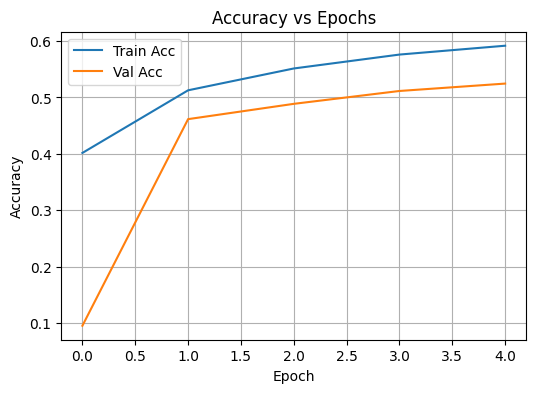

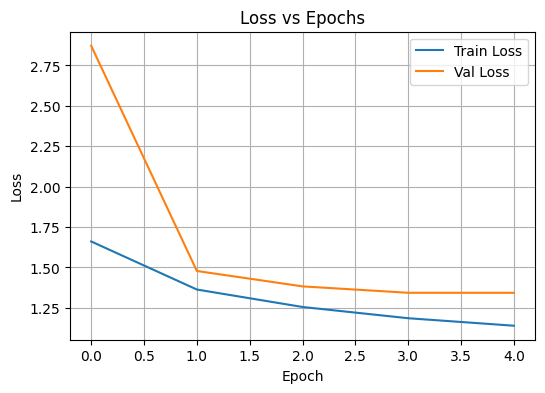


Test Accuracy: 0.5248

Classification Report:

              precision    recall  f1-score   support

    airplane       0.50      0.67      0.57      1000
  automobile       0.75      0.57      0.64      1000
        bird       0.32      0.56      0.40      1000
         cat       0.42      0.27      0.33      1000
        deer       0.42      0.50      0.45      1000
         dog       0.88      0.03      0.05      1000
        frog       0.59      0.78      0.67      1000
       horse       0.66      0.54      0.59      1000
        ship       0.71      0.55      0.62      1000
       truck       0.58      0.80      0.67      1000

    accuracy                           0.52     10000
   macro avg       0.58      0.52      0.50     10000
weighted avg       0.58      0.52      0.50     10000



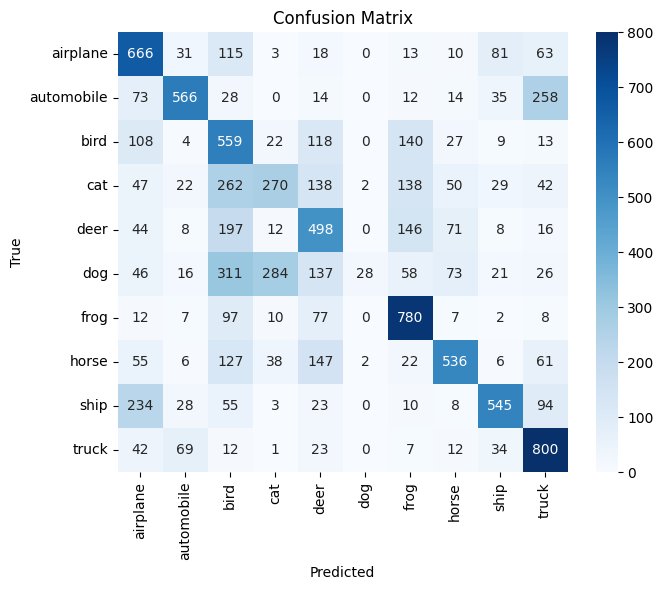

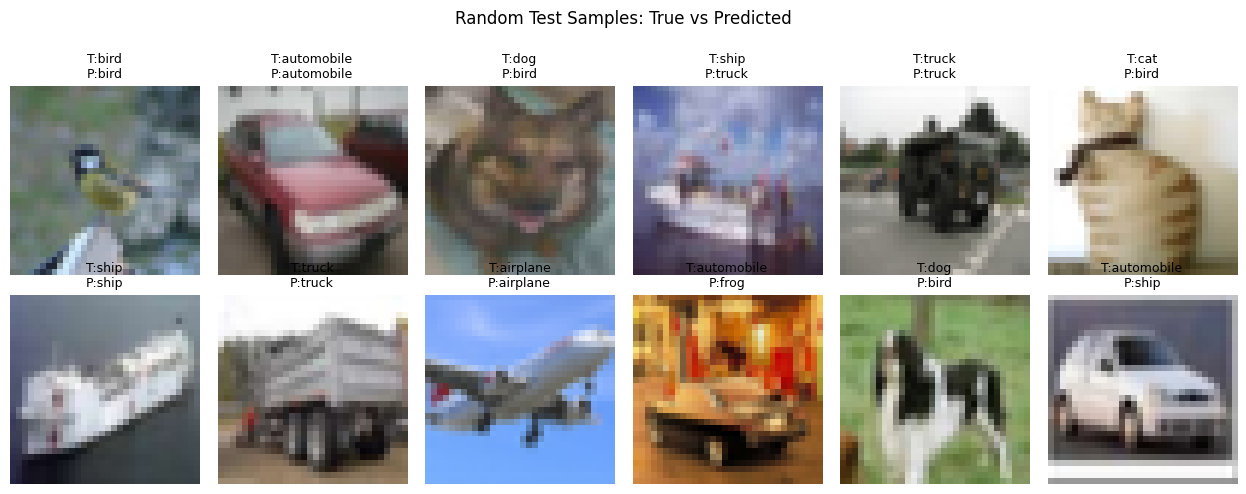


Parameter Breakdown:
Total params: 42,266
Expansion 1x1 params (approx): 0
Depthwise 3x3 params: 1,728
Pointwise 1x1 params: 37,104
SE params (two 1x1s): 0


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


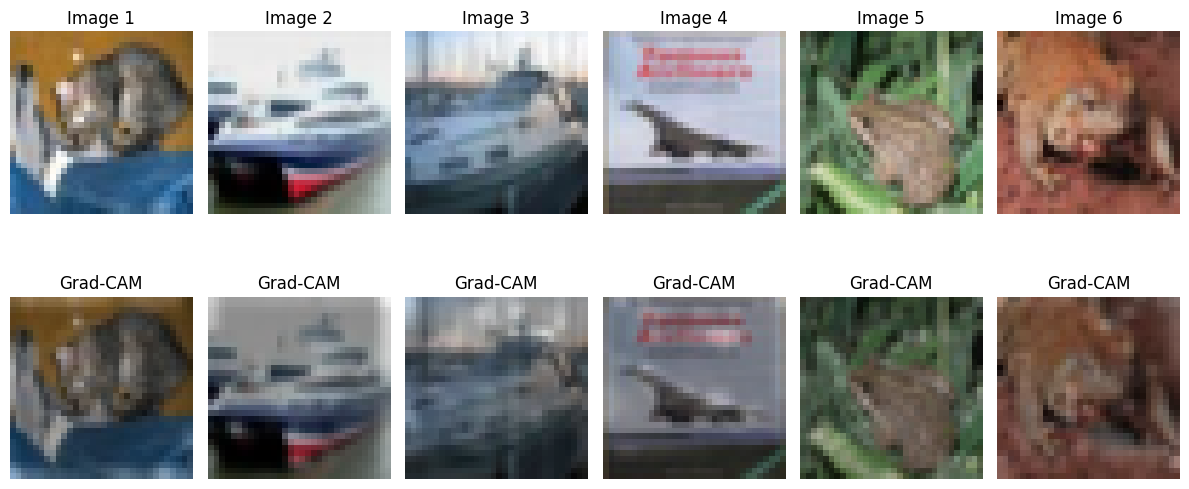

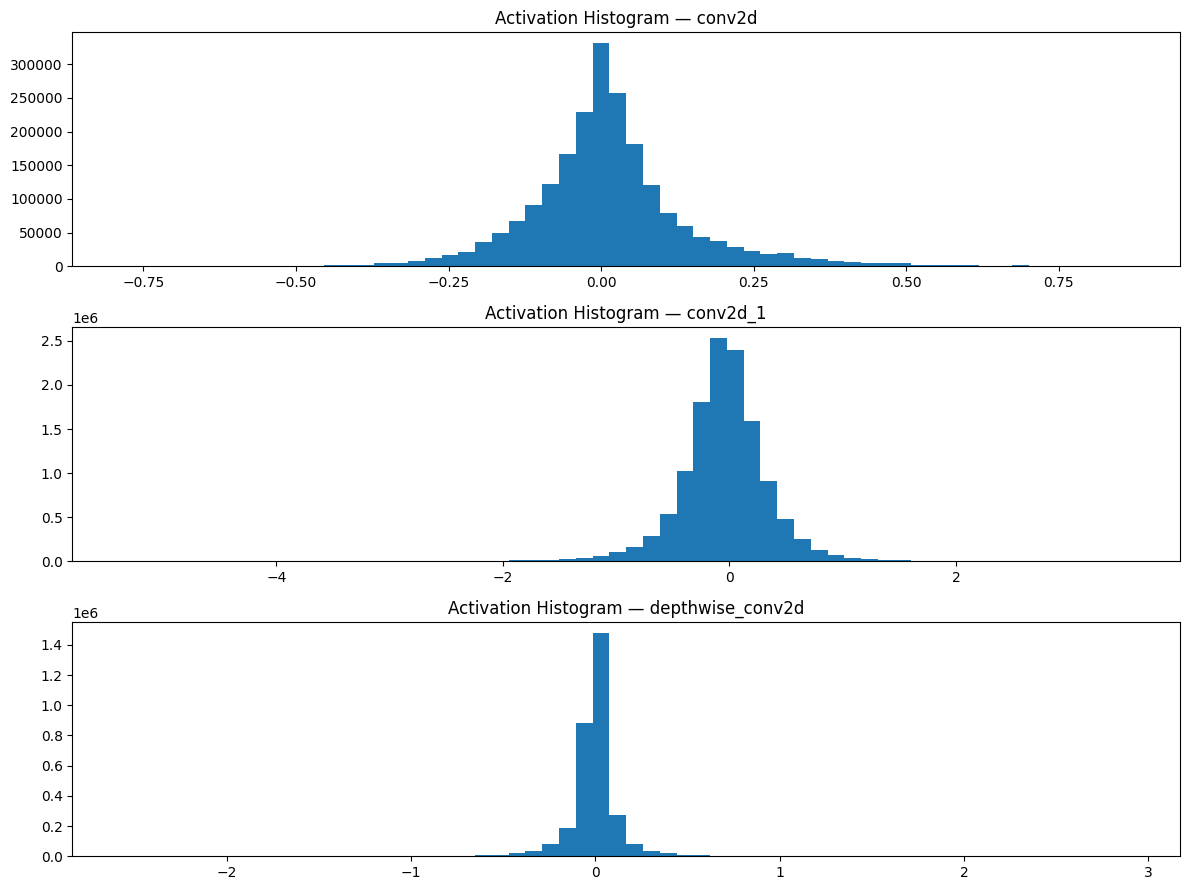

In [25]:
# -----------------------------
# Run end-to-end (5 epochs)
# -----------------------------

if __name__ == "__main__":
    # Tiny compound scaling example (alpha=1.0, r=32 keeps it CIFAR-native but variables exposed)
    alpha = 1.0
    r = 32

    (x_train, y_train, y_train_cat), (x_test, y_test, y_test_cat) = load_data(img_size=r)

    model = build_efficientnet_one_block(alpha=alpha, img_size=r)
    model.summary()

    history = model.fit(
        x_train, y_train_cat,
        validation_split=0.2,
        epochs=5,
        batch_size=128,
        verbose=1
    )

    plot_history(history)

    # Evaluate & predictions
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    y_probs = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = y_test.flatten()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    plot_confusion(y_true, y_pred, CLASS_NAMES)
    show_sample_predictions(x_test, y_true, y_pred, CLASS_NAMES, n=12)

    summarize_params(model)

    # Grad-CAM on a handful of test images
    grad_cam(model, x_test[:6])

    # Optional: activation histograms on a small batch
    activation_histograms(model, x_test[:64])
